This dataset uses the CBIS images from dataset 9. The DDSM images are created WITHOUT the thresholds on the mean and variance so that all images are included, even those with just background or content other than scan. This is so that the model can take an entire mammogram as input and predict whether each square contains an abnormality. Currently the model can predict individual tiles well, but behaves bizarrely when given a whole image, especially on tiles which also contain background.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from mammo_utils import random_flip_image
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the data
train_cbis_slices = np.load(os.path.join("data", "cbis_train_slices11.npy"))
train_cbis_labels = np.load(os.path.join("data", "cbis_train_labels11.npy"))
train_cbis_filenames = np.load(os.path.join("data", "cbis_train_names11.npy"))

test_cbis_slices = np.load(os.path.join("data", "cbis_test_slices11.npy"))
test_cbis_labels = np.load(os.path.join("data", "cbis_test_labels11.npy"))
test_cbis_filenames = np.load(os.path.join("data", "cbis_test_names11.npy"))

print("CBIS Train Images:", train_cbis_slices.shape)
print("CBIS Test Images:", test_cbis_slices.shape)

CBIS Train Images: (33241, 288, 288, 1)
CBIS Test Images: (8020, 288, 288, 1)


In [3]:
train_cbis_slices[0].dtype

dtype('uint8')

In [4]:
# create the test data - in order to make sure the data sets don't overlap we will splt the cbis images evenly into test
# and validation now. In order to try to segregate images by patient we will just split the data down the middle. 
# Since each mask can have at most 4 images this should keep overlap to a minimum
test_size = test_cbis_slices.shape[0] // 2

split_test_cbis_slices = test_cbis_slices[:test_size,:,:,:]
split_cv_cbis_slices = test_cbis_slices[test_size:,:,:,:]

split_test_cbis_labels = test_cbis_labels[:test_size]
split_cv_cbis_labels = test_cbis_labels[test_size:]

split_test_cbis_filenames = test_cbis_filenames[:test_size]
split_cv_cbis_filenames = test_cbis_filenames[test_size:]

print("Test Images:", split_test_cbis_slices.shape)
print("CV Images:", split_cv_cbis_slices.shape)

print("Test Labels:", split_test_cbis_labels.shape)
print("CV Labels:", split_cv_cbis_labels.shape)

Test Images: (4010, 288, 288, 1)
CV Images: (4010, 288, 288, 1)
Test Labels: (4010, 288, 288, 1)
CV Labels: (4010, 288, 288, 1)


## Shuffle the data and split it

In [5]:
# shuffle the training data
X_tr, y_tr, train_filenames = shuffle(train_cbis_slices, train_cbis_labels, train_cbis_filenames, random_state=7241972)

# shuffle the test data
X_te, y_te, test_filenames = shuffle(split_test_cbis_slices, split_test_cbis_labels, split_test_cbis_filenames, random_state=228859)

# shuffle the cv data
X_cv, y_cv, cv_filenames = shuffle(split_cv_cbis_slices, split_cv_cbis_labels, split_cv_cbis_filenames, random_state=21777)


print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (33241, 288, 288, 1)
X_te (4010, 288, 288, 1)
X_cv (4010, 288, 288, 1)


In [14]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [15]:
# write train data to tfrecords in 5 batches
import math
num_batches = 5
batch_size = math.ceil(X_tr.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training11_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is an error skip this index
        try:
            label = y_tr[idx]
            label_raw = label.tostring()
            image = X_tr[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _bytes_feature(label_raw),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

In [9]:
## save the test data
np.save(os.path.join("data", "test11_data.npy"), X_te)
np.save(os.path.join("data", "test11_labels.npy"), y_te)
np.save(os.path.join("data", "test11_filenames.npy"), test_filenames)

In [10]:
# save the validation data
np.save(os.path.join("data", "cv11_data.npy"), X_cv)
np.save(os.path.join("data", "cv11_labels.npy"), y_cv)
np.save(os.path.join("data", "cv11_filenames.npy"), cv_filenames)

## Verify that the data was written correctly

In [2]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.string),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = tf.decode_raw(features['label'], tf.uint8)
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [288, 288, 1])
    label = tf.reshape(label, [288, 288, 1])
    
    return label, image

In [7]:
label, image = read_and_decode_single_example(["data/training11_0.tfrecords", "data/training11_1.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

# contrast_img = tf.image.adjust_contrast(images_batch, 2.0)
la_max = tf.reduce_max(labels_batch, axis=[1,2])

# class_weight = tf.constant([4.0,1.0,1.0,1.0, 1.0])
# weight_per_label = tf.transpose(tf.matmul(tf.cast(tf.one_hot(labels_batch, depth=5), tf.float32), tf.transpose(class_weight)))

global_step = tf.Variable(0, trainable=False)

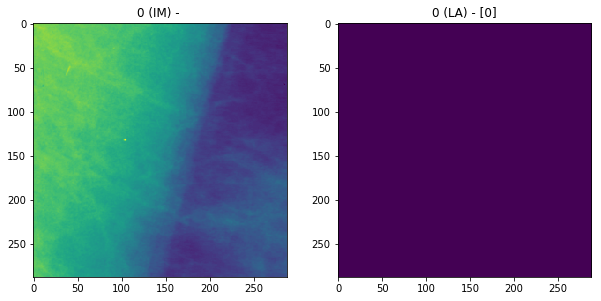

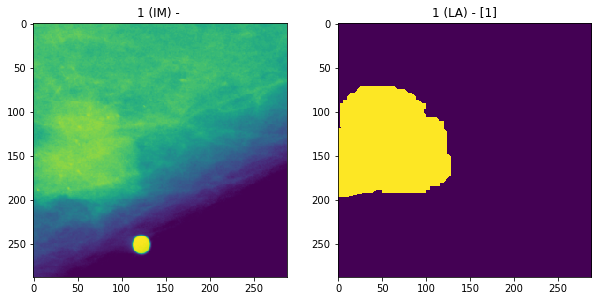

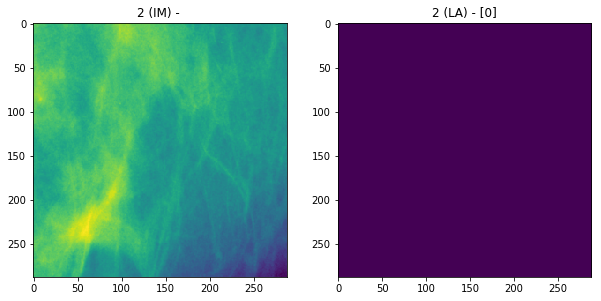

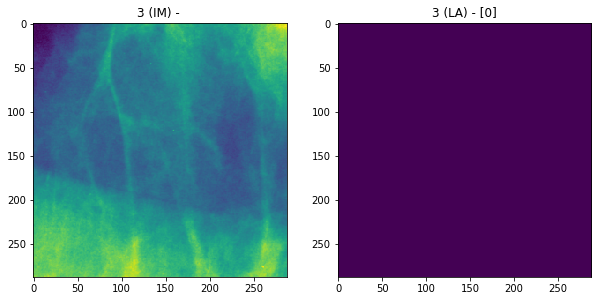

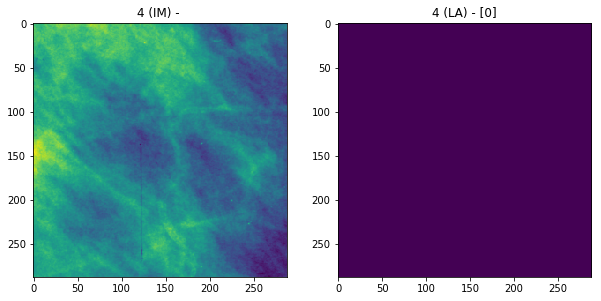

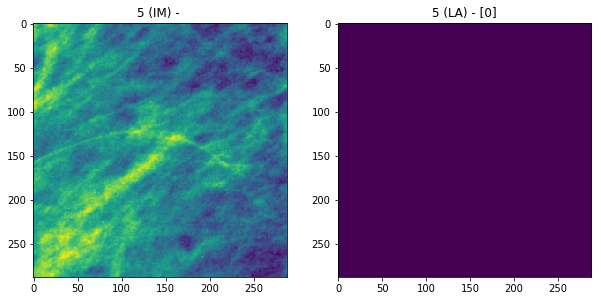

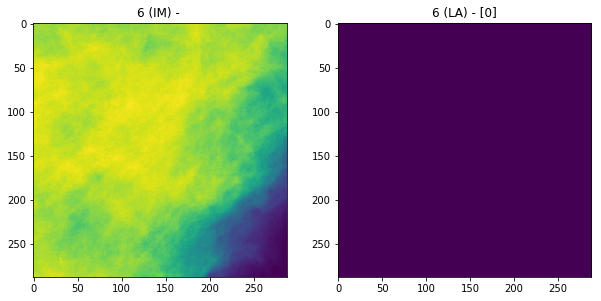

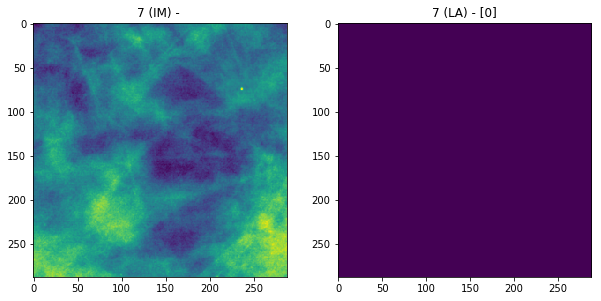

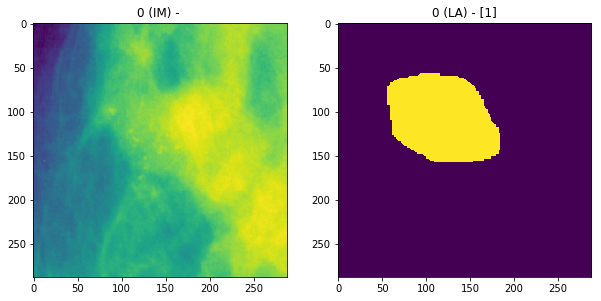

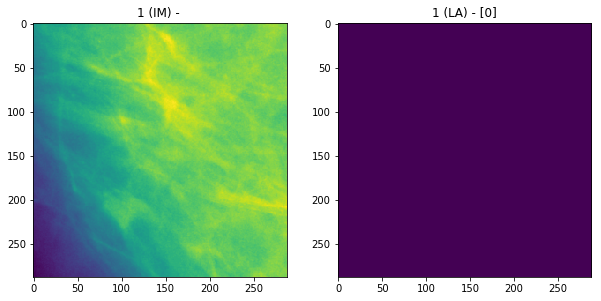

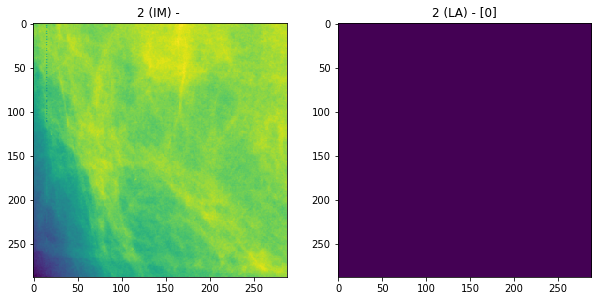

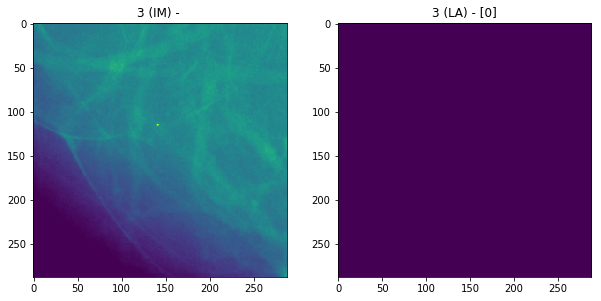

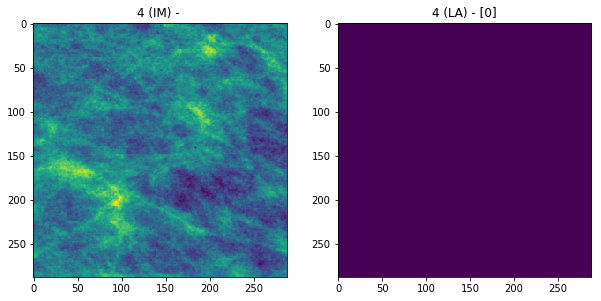

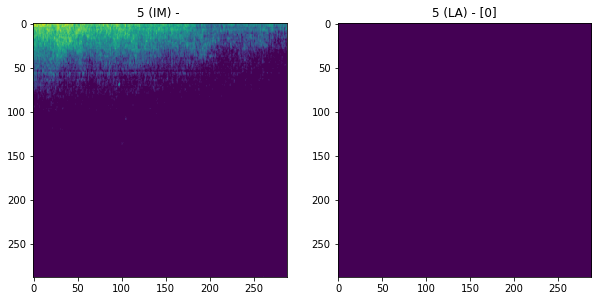

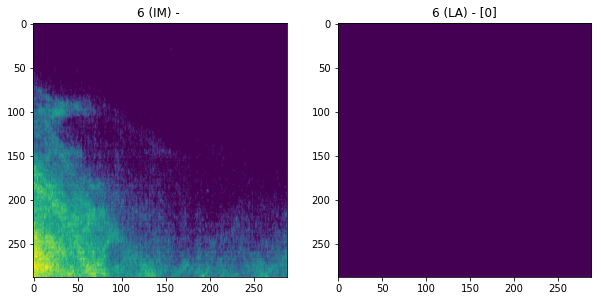

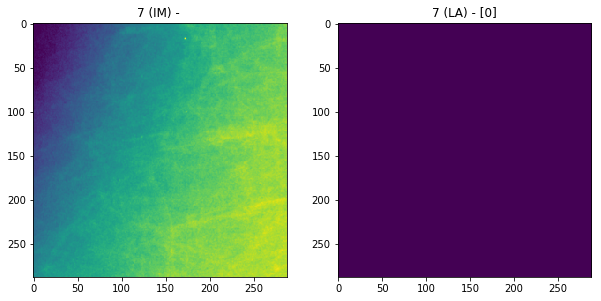

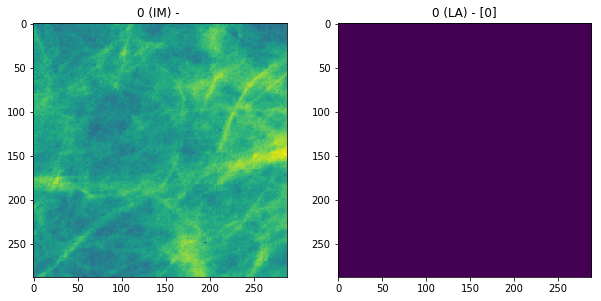

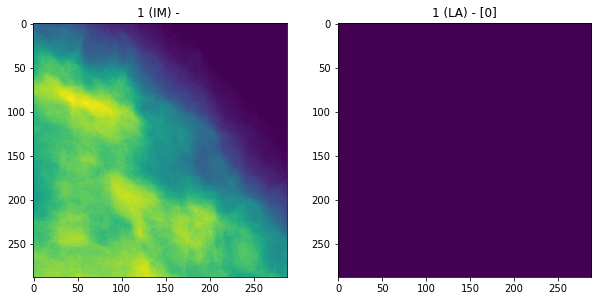

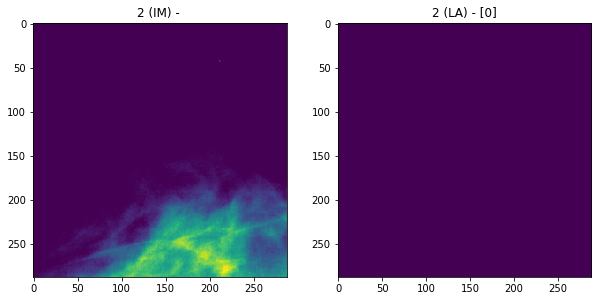

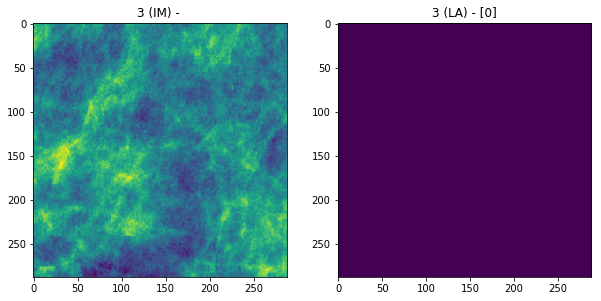

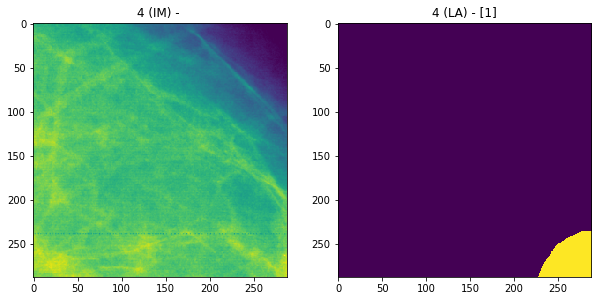

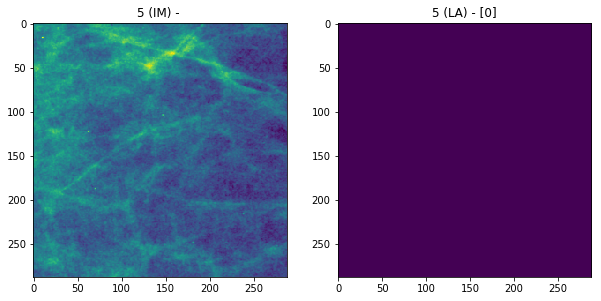

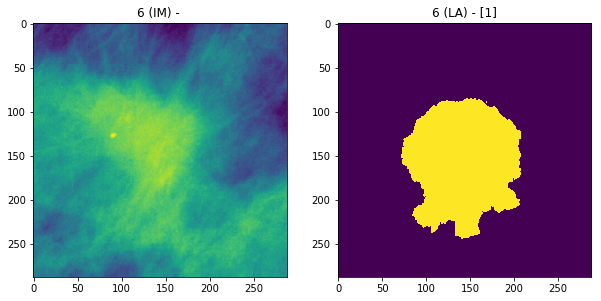

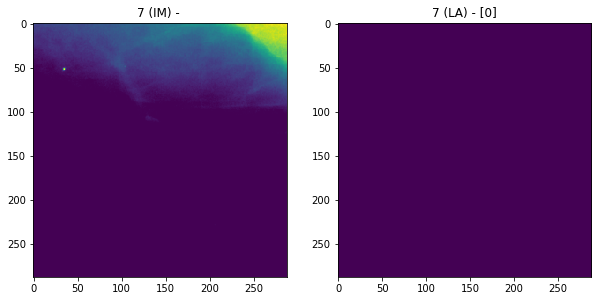

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b, bar = sess.run([labels_batch, images_batch, la_max])
        
        for i in range(8):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            ax[0].imshow(im_b[i].reshape([288,288]))
            ax[0].set_title(str(i) + " (IM) - ")
            
            ax[1].imshow(la_b[i].reshape([288,288]))
            ax[1].set_title(str(i) + " (LA) - " + str(bar[i]))
            plt.show()
            
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)